### PART:1

In [1]:
!pip install torch torchvision timm datasets transformers scikit-learn opencv-python matplotlib

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from transformers import ViTForImageClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
import io

class SpoofDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_bytes = self.dataset[idx]['cropped_image']
        if image_bytes is None:
            raise ValueError(f"No image data available at index {idx}")

        if isinstance(image_bytes, bytes):
            image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        else:
            image = image_bytes.convert("RGB")
    
        label = self.dataset[idx]['labels']
        if self.transform:
            image = self.transform(image)
        return image, label


class SpoofDetectionModel:
    def __init__(self, model_name='google/vit-base-patch16-224', num_labels=2):
        self.model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_labels, ignore_mismatched_sizes=True)
        self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)

    def train(self, dataloader, num_epochs=5):
        self.model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, labels in dataloader:
                self.optimizer.zero_grad()
                outputs = self.model(images).logits
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")

    def evaluate(self, dataloader):
        self.model.eval()
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for images, labels in dataloader:
                outputs = self.model(images).logits
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        
        return accuracy, precision, recall, f1

def load_and_prepare_dataset():
    dataset = load_dataset("nguyenkhoa/celeba-spoof-for-face-antispoofing-test")
    dataset = dataset['test'].shuffle(seed=42).select(range(int(0.2 * len(dataset['test']))))
    
    # Filter out invalid entries
    valid_dataset = [entry for entry in dataset if entry['cropped_image'] is not None]
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    spoof_dataset = SpoofDetectionDataset(valid_dataset, transform=transform)
    train_size = int(0.8 * len(spoof_dataset))
    test_size = len(spoof_dataset) - train_size
    train_dataset, test_dataset = random_split(spoof_dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader


if __name__ == "__main__":
    train_loader, test_loader = load_and_prepare_dataset()
    
    model = SpoofDetectionModel()
    model.train(train_loader)
    
    accuracy, precision, recall, f1 = model.evaluate(test_loader)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Loss: 0.06896752063435932
Epoch [2/5], Loss: 0.019377205527316456
Epoch [3/5], Loss: 0.010533939142062115
Epoch [4/5], Loss: 0.01452158758496546
Epoch [5/5], Loss: 0.016544286999550843
Accuracy: 0.99812734082397
Precision: 0.9984488107549121
Recall: 0.9989653388515262
F1-score: 0.9987070080165503


In [4]:
from datasets import load_dataset

In [1]:
print("hi")

hi


### PART:2

In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jydzm2jy
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jydzm2jy
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [3]:
import os

# Create directories if not exist
os.makedirs("coco", exist_ok=True)
os.chdir("coco")

# Download validation images and annotations
!wget -nc http://images.cocodataset.org/zips/val2017.zip
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -qn val2017.zip
!unzip -qn annotations_trainval2017.zip
os.chdir("..")


--2025-03-14 05:53:11--  http://images.cocodataset.org/zips/val2017.zip
54.231.195.1, 52.217.81.140, 52.217.10.244, ...taset.org)... 
connected. to images.cocodataset.org (images.cocodataset.org)|54.231.195.1|:80... 
200 OKequest sent, awaiting response... 
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  1.30MB/s    in 11m 8s  

2025-03-14 06:04:20 (1.16 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2025-03-14 06:04:21--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.49.145, 52.217.205.9, 16.182.33.105, ...
connected. to images.cocodataset.org (images.cocodataset.org)|52.216.49.145|:80... 
200 OKequest sent, awaiting response... 
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  1.44MB/s    in 5m 30s  

2025-03-14 06:09:5

In [5]:
pip install pycocotools

Note: you may need to restart the kernel to use updated packages.


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████████████████████████████████| 5000/5000 [00:36<00:00, 138.16it/s]


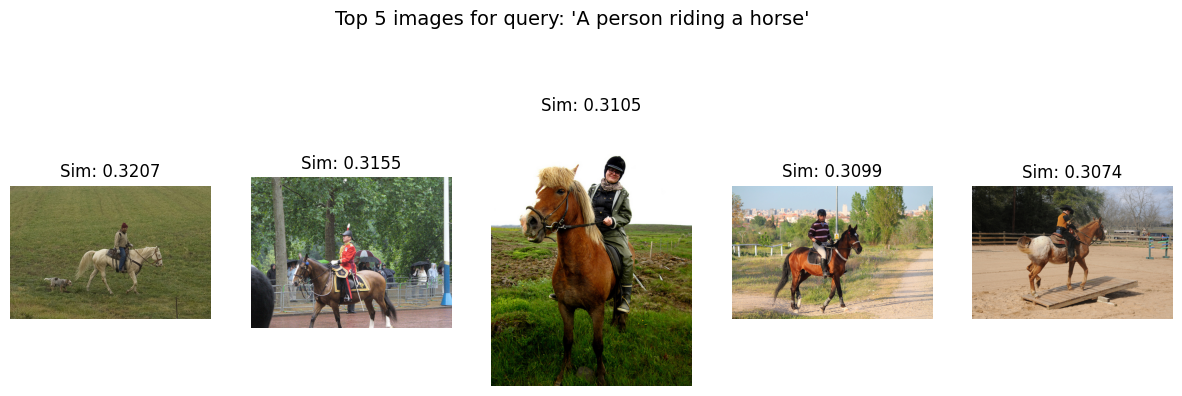

In [6]:
import torch
import clip
import numpy as np
import torchvision.transforms as transforms
import PIL.Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CocoCaptions
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

# Load COCO dataset
coco_dataset = CocoCaptions(
    root="coco/val2017",
    annFile="coco/annotations/captions_val2017.json",
    transform=preprocess
)

# Encode all images
image_embeddings = []
image_paths = []
with torch.no_grad():
    for i in tqdm(range(len(coco_dataset))):
        image, _ = coco_dataset[i]
        image = image.unsqueeze(0).to(device)
        image_embedding = model.encode_image(image).cpu().numpy()
        image_embeddings.append(image_embedding)
        image_paths.append(coco_dataset.ids[i])

image_embeddings = np.vstack(image_embeddings)  # Shape: (num_images, embedding_dim)

# Function to retrieve similar images
def retrieve_similar_images(text_query, top_k=5):
    # Encode text query
    with torch.no_grad():
        text_tokenized = clip.tokenize([text_query]).to(device)
        text_embedding = model.encode_text(text_tokenized).cpu().numpy()

    # Compute cosine similarity
    similarities = cosine_similarity(text_embedding, image_embeddings)[0]
    
    # Get top-k similar images
    top_indices = similarities.argsort()[-top_k:][::-1]
    top_similarities = similarities[top_indices]
    
    # Display results
    fig, axes = plt.subplots(1, top_k, figsize=(15, 5))
    fig.suptitle(f"Top {top_k} images for query: '{text_query}'", fontsize=14)

    for i, idx in enumerate(top_indices):
        image_path = f"coco/val2017/{image_paths[idx]:012d}.jpg"
        image = PIL.Image.open(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Sim: {top_similarities[i]:.4f}")
        axes[i].axis("off")

    plt.show()

# Example query
retrieve_similar_images("A person riding a horse")


###   PART:3

In [7]:
pip install diffusers transformers accelerate safetensors

  Using cached importlib_metadata-8.6.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached zipp-3.21.0-py3-none-any.whl.metadata (3.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 1.4 MB/s eta 0:00:001.2 MB/s eta 0:00:010m
Using cached importlib_metadata-8.6.1-py3-none-any.whl (26 kB)
Using cached zipp-3.21.0-py3-none-any.whl (9.6 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

# Load the model (Stable Diffusion v1.5)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)


2025-03-22 05:21:28.899859: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 05:21:29.003962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742635289.041380 3196697 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742635289.054582 3196697 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 05:21:29.151093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

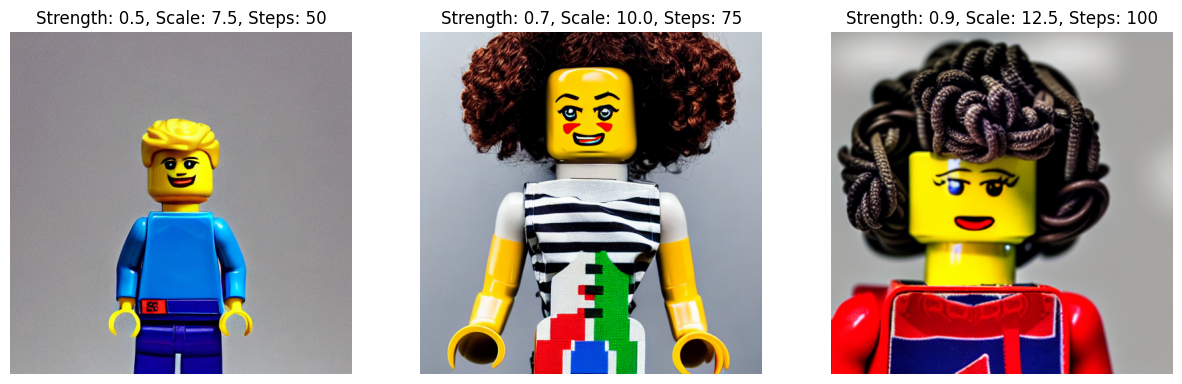

In [5]:
from PIL import Image

# Load an input image
image_path = "/home/taha/Downloads/doll/front.png"  # Change this to your image path
init_image = Image.open(image_path).convert("RGB").resize((512, 512))

# Define a text prompt
prompt = "Front view of a lego doll"

# Generate variations with different parameters
variations = [
    {"strength": 0.5, "guidance_scale": 7.5, "num_steps": 50},
    {"strength": 0.7, "guidance_scale": 10.0, "num_steps": 75},
    {"strength": 0.9, "guidance_scale": 12.5, "num_steps": 100},
]

fig, axes = plt.subplots(1, len(variations), figsize=(15, 5))

for i, params in enumerate(variations):
    image = pipe(prompt, image=init_image, strength=params["strength"],
                 guidance_scale=params["guidance_scale"], num_inference_steps=params["num_steps"]).images[0]
    
    axes[i].imshow(image)
    axes[i].set_title(f"Strength: {params['strength']}, Scale: {params['guidance_scale']}, Steps: {params['num_steps']}")
    axes[i].axis("off")

plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

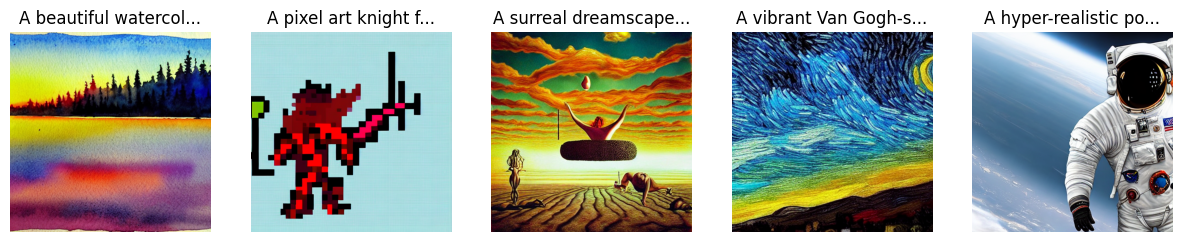

In [3]:
prompts = [
    "A beautiful watercolor painting of a sunset",
    "A pixel art knight fighting a dragon",
    "A surreal dreamscape in the style of Salvador Dalí",
    "A vibrant Van Gogh-style night sky",
    "A hyper-realistic portrait of an astronaut in space"
]

guidance_scale = 8.0
num_steps = 50

fig, axes = plt.subplots(1, len(prompts), figsize=(15, 5))

for i, prompt in enumerate(prompts):
    image = pipe(prompt, guidance_scale=guidance_scale, num_inference_steps=num_steps).images[0]
    
    axes[i].imshow(image)
    axes[i].set_title(prompt[:20] + "...")
    axes[i].axis("off")

plt.show()
